<h1><center>High Resolution Spatial Mapping of Soil Nutrients</center></h1>

In [194]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split,KFold
from pykrige.ok import OrdinaryKriging
import skgstat as skg
plt.style.use('ggplot')
os.environ['SKG_SUPPRESS'] = "true"
%matplotlib inline

In [220]:
Kscaled = pd.read_csv("../Dataset/Kscaled.csv")
Oscaled = pd.read_csv("../Dataset/Ocscaled.csv")
Pscaled = pd.read_csv("../Dataset/Pscaled.csv")
Nscaled = pd.read_csv("../Dataset/scaledN.csv")

## Data Analysis

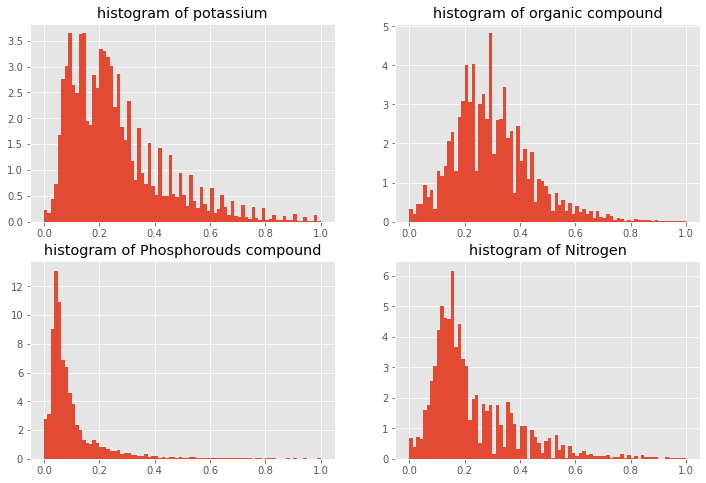

In [221]:
_,ax = plt.subplots(2,2,figsize = (12,8))
ax[0,0].hist(Kscaled['Scaled K'],bins = 80,density = True)
ax[0,0].set_title("histogram of potassium")
ax[0,1].hist(Oscaled['Scaled Oc'],bins = 80,density = True)
ax[0,1].set_title("histogram of organic compound")
ax[1,0].hist(Pscaled['Scaled P'],bins = 80,density = True)
ax[1,0].set_title("histogram of Phosphorouds compound")
ax[1,1].hist(Nscaled['Scaled N'],bins = 80,density = True)
ax[1,1].set_title("histogram of Nitrogen")
plt.show()
             

# Ordinary Kriging

Here we will be implemeting the ordinary Kriging just for the sake of understanding. Even though we know that our 
data distribution does not follow complete Gaussian distribution as it is evident from the above plots.

In [234]:
def create_grid():
    lon = np.linspace(17.895,20.598,10)
    lat = np.linspace(73.384,76.675,10)
    return lon,lat
    

In [223]:
def OrdinaryK(lat,lon,z,model,num_lags,verbose = True,enable_plotting = True,coordinates_type = "geographic"):
    # performs ordinary kriging
    OK = OrdinaryKriging(lon,
                         lat,
                         z,
                         weight=True,
                         variogram_model = model,
                         verbose = verbose,
                         nlags = num_lags,
                         enable_plotting = enable_plotting,
                         coordinates_type=coordinates_type,
                         exact_values=True,
                         )
    return OK
    

In [224]:
# Pscaled = Pscaled.iloc[np.random.randint(2000,25000,10000)].reset_index(drop = True)

In [225]:
# # Kscaled.reset_index()
# Pscaled = Pscaled.(5000)

In [226]:
def kfold_model(x,y,model,n_lags):
    #perform k-fold cross validation on the model
    kf  = KFold(n_splits = 10,shuffle = True)
    r2_cum = 0 
    for train_index,test_index in kf.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
        ok = model(x_train[:,0],x_train[:,1],y_train,"spherical",n_lags,enable_plotting = False,verbose = False) #n_lags can be tuned  
        pred = ok.execute(style ='points',xpoints = x_test[:,0],ypoints = x_test[:,1])[0].data
        r2_cum+=r2_score(y_test,pred)
    score = r2_cum/10
    print(f"R^2 score for give model is {score}")
    print("model is satisfactory") if score >= 0.8 else print("model need to be tuned or try some other way")

In [212]:
#let' evaluate our model
# kfold_model(np.asarray(Kscaled[['Longitude','Latitude']]),Kscaled['Scaled P'],OrdinaryK,30)

As we can see that our `Ordianry Kriging` model is not performing better and we have to choose the `expert-based system` model.
Let's dig a little deeper.
__Why does our model is not performing well?__
* It is because we have already seen that the given datasets does not follow the Gaussian distribution(not necessarily).There might be reasons behind this. BUt we will not see that here. 
* Our dataset might have certain trend that we are not able to identify.
* Therefore, We  have to modify our models.  Ordianry kriging is a stochastic process. There might be some physical factors affecting the randomness of the data. 
* we can try some deterministic processes but that won't be suitable here. Deterministic process are mostly used in time-series data model.
* If we are not certain about the factors or underlying trends, then we can try some hybrid models like Regression-Kriging(RK).we wont be touchig those here as they are traditional models and have already been in practice since 90s.
* we have decided is to use `advanced expert-based system` to plot the high-resolution spatial map.

In [227]:
def train_val_model(x,y,ok):
    x_train,x_val,y_train,y_val = train_test_split(np.asarray(x),y,test_size = 0.2,random_state = 42)
    trained_model = ok(x_train[:,0],x_train[:,1],y_train,"spherical",20)
    print("\n-----------------------Performing validation------------------------------\n")
    pred = trained_model.execute(style ='points',xpoints = x_val[:,0],ypoints = x_val[:,1])[0].data
    score = r2_score(y_val,pred)
    print(f"validation score is {score}")
    
    return trained_model

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 0.03357334233936351
Full Sill: 0.03357334233936387
Range: 3.2293252546404263
Nugget: 3.6287960839470135e-16 



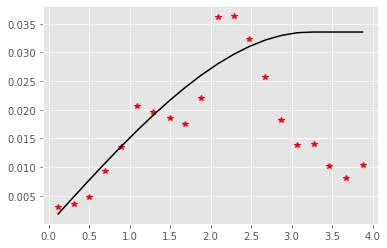

Calculating statistics on variogram model fit...

-----------------------Performing validation------------------------------

Executing Ordinary Kriging...

validation score is -0.22798283224966354


In [228]:
model_train = train_val_model(Pscaled[['Longitude','Latitude']],Pscaled['Scaled P'],OrdinaryK)

In [229]:
# model_train.get_variogram_points()

In [235]:
def interpolate_grid(model):
    grid_lon,grid_lat = create_grid()
    val,var = model.execute("grid",grid_lon,grid_lat,backend ="C",n_closest_points = 100)
    plt.figure(figsize=(8,8))
    plt.imshow(val,extent = [17.895,20.598,73.384,76.675],origin = "lower")
    plt.xticks(grid_lon)
    plt.yticks(grid_lat)
    plt.title("Grid plot")
#     plt.axis('off')
    plt.grid(b=None)
    plt.show()
    return val,var

Executing Ordinary Kriging...



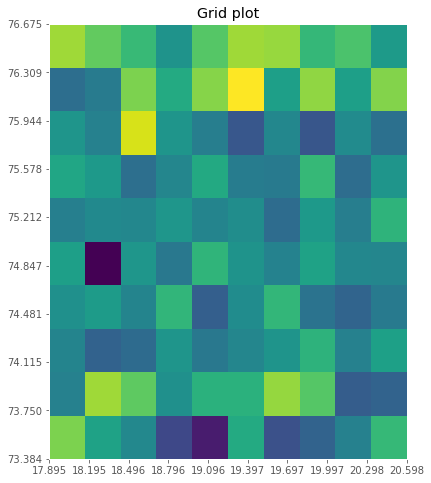

In [237]:
val,var = interpolate_grid(model_train)

In [1]:
val

NameError: name 'val' is not defined

__Caution__ 💀💀<br>
Our Result is not satisfactory at all. We can make it better by tuning the hyperparameter `n_closest_points`. but training and testing would take more time and `Pykrige` library is not yet optimized completely. Feel free to play around with this notebook. Make sure you have enough RAM and Virtual memory to run the entire Dataset. Because It is finding optimum solution in vectorized manner and would definitely consume more RAM given the data type is `float64`.
